In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.metrics import brier_score_loss, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

/Users/xiaozhezhang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


| market_category | feature_name | id |
|-----------------|--------------|----|
| Bank            | bac          |  1 |
| Bank            | citi         |  2 |
| Commodity       | corn         |  3 |
| Currency        | euro         |  4 |
| Commodity       | gold         |  5 |
| Inflation       | infl5y       |  6 |
| Commodity       | iyr          |  7 |
| Currency        | pound        |  8 |
| Commodity       | silver       |  9 |
| Commodity       | soybns       | 10 |
| Equity          | sp12m        | 11 |
| Equity          | sp6m         | 12 |
| Commodity       | wheat        | 13 |
| Currency        | yen          | 14 |


Return Model (Log Price)

In [2]:
df = pd.read_csv("Output_Data/mpd_sp500.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# forwards filling
df = df.fillna(method='ffill')
# create a new df that extract the columns of SP_adj_close	SP_lg_pr	SP_lg_ret(%)	VIX
data = df[['SP_adj_close', 'SP_lg_pr', 'SP_lg_ret(%)', 'VIX']]

# keep columns that have names containing f11 and f12 only
df = df.filter(regex='f11|f12')

# merge data to df merge on index
df = pd.merge(df, data, left_index=True, right_index=True, how='left')

In [3]:
# drop columns that has "maturity_target" , "lg_change_decr", and "lg_change_incr" in the column name; those are irrelevant for feature selection
df = df[df.columns.drop(list(df.filter(regex='maturity_target')))]
df = df[df.columns.drop(list(df.filter(regex='lg_change_decr')))]
df = df[df.columns.drop(list(df.filter(regex='lg_change_incr')))]
df = df[df.columns.drop(list(df.filter(regex='SP_adj_close')))]

# drop SP_lg_ret(%)	
df = df.drop(['SP_lg_ret(%)'], axis=1)
# df = df.drop(['SP_lg_pr'], axis=1)
df = df.drop(['VIX'], axis=1)

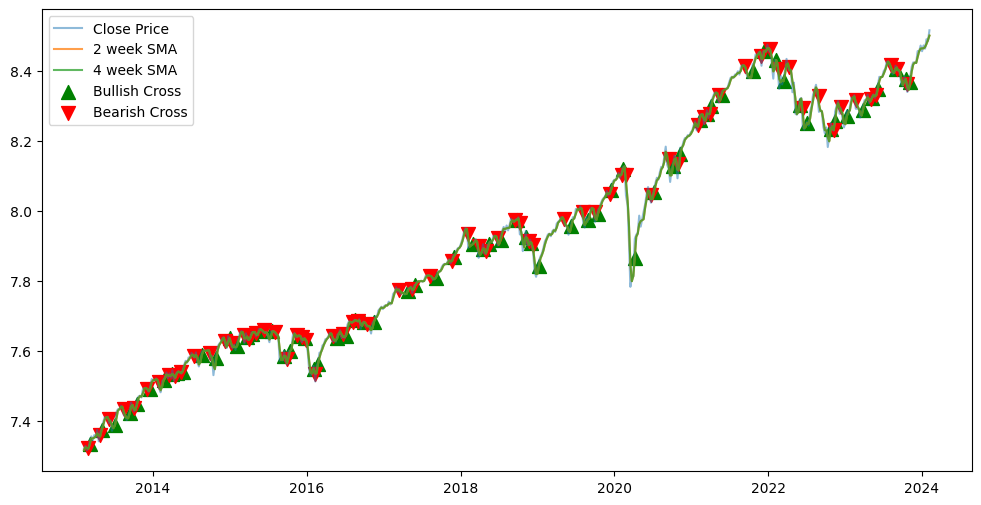

In [4]:
df['2_week_mean'] = df['SP_lg_pr'].rolling(window=2).mean()
df['4_week_mean'] = df['SP_lg_pr'].rolling(window=4).mean()

# Identify bullish and bearish crossover points
df['Bullish_Cross'] = (df['2_week_mean'] > df['4_week_mean']) & (df['2_week_mean'].shift(1) <= df['4_week_mean'].shift(1))
df['Bearish_Cross'] = (df['2_week_mean'] < df['4_week_mean']) & (df['2_week_mean'].shift(1) >= df['4_week_mean'].shift(1))
df.dropna(inplace=True)
# visualization
plt.figure(figsize=(12, 6))
plt.plot(df['SP_lg_pr'], label='Close Price', alpha=0.5)
plt.plot(df['2_week_mean'], label='2 week SMA', alpha=0.75)
plt.plot(df['2_week_mean'], label='4 week SMA', alpha=0.75)

# label the crossover
plt.scatter(df[df['Bullish_Cross']].index, df['2_week_mean'][df['Bullish_Cross']], color='green', label='Bullish Cross', marker='^', s=100)
plt.scatter(df[df['Bearish_Cross']].index, df['4_week_mean'][df['Bearish_Cross']], color='red', label='Bearish Cross', marker='v', s=100)

plt.legend()
plt.show()

In [5]:
df['Signal'] = 0  
df.loc[df['2_week_mean'] > df['4_week_mean'], 'Signal'] = 1 
df.loc[df['2_week_mean'] < df['4_week_mean'], 'Signal'] = -1 
df['Signal']

Date
2013-02-07    1
2013-02-14    1
2013-02-21    1
2013-02-28   -1
2013-03-07    1
             ..
2024-01-10    1
2024-01-17    1
2024-01-24    1
2024-01-31    1
2024-02-07    1
Name: Signal, Length: 574, dtype: int64

In [6]:
# Generate lagged variables from f1_mu to SP_lg_pr
lags = 6
for lag in range(1, lags+1):
    # for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('SP_lg_ret_vol')+1]:
    # for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('VIX')+1]: 
    for col in df.columns[df.columns.get_loc('f11_mu'):df.columns.get_loc('Signal')-1]: 
    #for col in df.columns[df.columns.get_loc('f11_mu'):df.columns.get_loc('SP_lg_ret(%)')+1]:  
        if(col[:3]=='f11' or col[:3]=='f12' or col[:3]=='SP_'):
            # print(col) 
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_68582/4273606458.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_68582/4273606458.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_68582/4273606458.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

In [7]:
df.columns

Index(['f11_mu', 'f11_sd', 'f11_skew', 'f11_kurt', 'f11_p10', 'f11_p50',
       'f11_p90', 'f11_prDec', 'f11_prInc', 'f12_mu',
       ...
       'f12_mu_lag6', 'f12_sd_lag6', 'f12_skew_lag6', 'f12_kurt_lag6',
       'f12_p10_lag6', 'f12_p50_lag6', 'f12_p90_lag6', 'f12_prDec_lag6',
       'f12_prInc_lag6', 'SP_lg_pr_lag6'],
      dtype='object', length=138)

In [8]:
df_lagged = df.copy()
# drop NA rows
df_lagged = df_lagged.dropna()
df_lagged['Next_Week_Signal'] = df_lagged['Signal'].shift(-1) # align y with X for regression
df_lagged = df_lagged.dropna()

In [9]:
df_lagged.drop( ['2_week_mean',
 '2_week_mean',
 'Bullish_Cross',
 'Bearish_Cross',
 'Signal'],axis=1,inplace=True)

In [10]:
# Define the target variable
start_colunm = df_lagged.columns.get_loc('f11_mu')
# end_column = df_lagged.columns.get_loc('VIX_lag6')
end_column = df_lagged.columns.get_loc('SP_lg_pr_lag6')
#end_column = df_lagged.columns.get_loc('SP_lg_ret(%)_lag6')

column_index = list(range(start_colunm, end_column+1))

X = df_lagged.iloc[:, column_index]

# y = df_lagged['SP_lg_ret(%)'] 
y = df_lagged['Next_Week_Signal']

split_index = int(len(X)*0.75)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train,y_train)
print("In Sample accuracy: ", f'{knn_clf.score(X_train, y_train):.5f}')
print()
print("Out of Sample accuracy: ", f'{knn_clf.score(X_test, y_test):.5f}')
print()
# lasso coefficients with corresponding feature names
# lasso_coef = pd.DataFrame(lassoCV.coef_, index=X.columns, columns=['coef'])
# lasso_coef = lasso_coef[lasso_coef.coef != 0]

# print("Number of features selected: ", len(lasso_coef))
# print(lasso_coef)

print()
# show the predicted value
knn_y_pred = knn_clf.predict(X_test)
# calculate the MSE, RMSE, and MAE
from ISLP import confusion_table
confusion_table(knn_y_pred,y_test)


In Sample accuracy:  0.78353

Out of Sample accuracy:  0.65493




Truth,-1.0,1.0
Predicted,,
-1.0,12,7
1.0,42,81
